## Seminario de Ciencias de la Computación A: Neuronas y redes neuronales: modelos y aplicaciones a la ciencia de datos
--- 

Notebook for model training and model prediction based on hiperparameters found using `GridSearchCV` and `KerasRegressor`.

### Developed by:
- Brito Juárez Britny
- Medel Piña Alberto Natanael
- Medina Ruiz Arturo Itzcóatl
- Ramírez Plascencia Tania


In [1]:
import pickle 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from time import gmtime, strftime

In [2]:
# Creation of time windows
def time_window(series, step_length, target_column):
  # X for attributes Y for target
  X_series = []
  Y_series = []
  last = len(series) - sequence_length - 1
  for i in range(last):
    X_series.append(series[i : i + sequence_length])
    Y_series.append(series[i + sequence_length, target_column])

  X_series = np.array(X_series)
  Y_series = np.array(Y_series)
  X_series = np.delete(X_series, target_column, 2) # Drop target from training
  return X_series, Y_series

In [3]:
train = pd.read_feather('/kaggle/input/clean02/training_30m_100p_gap.feather')
train = train[['Close_Norm', 'High_Norm', 'Low_Norm', 'Gap',
               'Close_Rate', 'Volume_Log', 'Volume_Qty']]

validation = pd.read_feather('/kaggle/input/clean02/validation_30m_100p_gap.feather')
validation = validation[['Close_Norm', 'High_Norm', 'Low_Norm', 'Gap',
                         'Close_Rate', 'Volume_Log', 'Volume_Qty']]

sequence_length = 30
train_vals      = train.values
validation_vals = validation.values

X_train, Y_train = time_window(train_vals, sequence_length, 0)
X_val, Y_val     = time_window(validation_vals, sequence_length, 0)

In [4]:
"""
Model hiperparameters (obtained via GridSearchCV)
- Network weight initializer: normal
- Number of cells: 25
- Optimizer: adam
- Learning rate: 0.001
- Batch size: 16
- Epochs: 100 (may vary depending on results)
"""
model = keras.Sequential()
model.add(keras.layers.LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'))
model.add(keras.layers.Dense(1))

"""
We'll use Huber loss, since it can use MSE or MAE 
depending on the case.
"""
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss=keras.losses.Huber(),
              metrics=['mae'])

model_history = model.fit(X_train, Y_train, 
                          batch_size=16, epochs=100,
                          validation_data=(X_val, Y_val))
timestamp = strftime("%a, %d %b %Y", gmtime())
model.save(f'model_{timestamp}')

Epoch 1/100
5034/5034 [==============================] - 31s 5ms/step - loss: 3.3109e-04 - mae: 0.0078 - val_loss: 1.4061e-05 - val_mae: 0.0034
Epoch 2/100
5034/5034 [==============================] - 24s 5ms/step - loss: 1.4875e-05 - mae: 0.0037 - val_loss: 9.5208e-06 - val_mae: 0.0028
Epoch 3/100
5034/5034 [==============================] - 24s 5ms/step - loss: 1.2293e-05 - mae: 0.0034 - val_loss: 9.4861e-06 - val_mae: 0.0029
Epoch 4/100
5034/5034 [==============================] - 24s 5ms/step - loss: 1.0975e-05 - mae: 0.0031 - val_loss: 7.9593e-06 - val_mae: 0.0025
Epoch 5/100
5034/5034 [==============================] - 24s 5ms/step - loss: 9.9554e-06 - mae: 0.0029 - val_loss: 1.4313e-05 - val_mae: 0.0042
Epoch 6/100
5034/5034 [==============================] - 24s 5ms/step - loss: 9.8527e-06 - mae: 0.0029 - val_loss: 8.8746e-06 - val_mae: 0.0029
Epoch 7/100
5034/5034 [==============================] - 24s 5ms/step - loss: 9.2336e-06 - mae: 0.0028 - val_loss: 9.0807e-06 - val_mae:

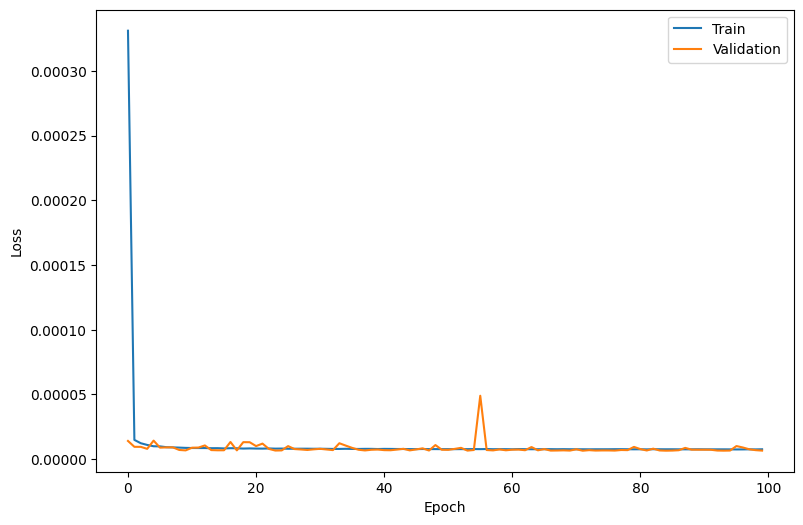

In [5]:
plt.figure(figsize=(9,6))
plt.plot(model_history.history['loss'], label='Train')
plt.plot(model_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'model_{timestamp}')
plt.show()

In [ ]:
!zip -r model_v0.zip  /kaggle/working/model_Sun,\ 19\ Nov\ 2023

## Prediction

In [13]:
forecast = model.predict(X_val)

629/629 [==============================] - 1s 2ms/step


In [14]:
forecast = keras.metrics.mean_absolute_error(Y_val, forecast).numpy()
print(keras.metrics.mean_absolute_error(Y_val, forecast))

tf.Tensor(0.44119683, shape=(), dtype=float32)


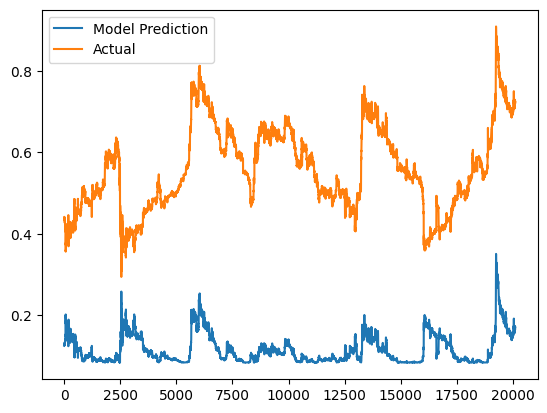

In [15]:
plt.plot(forecast, label='Model Prediction')
plt.plot(Y_val, label='Actual')
plt.legend()
plt.savefig(f'Results_mae_model{timestamp}')
plt.show()